In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.ma.core import mean
from ast import literal_eval
import math 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ast
from openai import OpenAI
import os
import json
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import re

In [2]:
def tag_classifier(tag):
    categories = ["World Cuisines", "Regional Cuisines", "Dish Types", "Proteins", "Vegetables", "Fruits", "Grains", "Dairy", "Nuts and Seeds", "Herbs and Spices", "Baking Ingredient", "Oils and Vinegars", "Legumes", "Meal Type", "Main Course", "Special Occasions", "Dietary Restrictions", "Cooking Technique", "Recipe Difficulty", "Appliances/Equipment", "Preparation/Techniques", "Time/Difficulty", "Occasions/Events", "Miscellaneous", "Other", "Uncategorized"]
    msg = "Please help me categorize the following tag into one of the following categories:\n\n"
    msg += '\n'.join(categories) + '\n\n'
    msg += "Tag:\n" + tag
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": msg}])
    result = response.choices[0].message.content.strip()
    if result in categories:
        return result    
    return None

def get_corresponding_tags(keys, dictionary):
  output = []
  for key in keys:
    if key in dictionary:
      output.append(dictionary[key])
  output_list = [tag for list in output for tag in list]
  return output_list

def has_desired_tags(row, tag_list):
    return any(tag in row['tags'] for tag in tag_list)

def flatten(list):
    return [element for sublist in list for element in sublist]

def get_recipe_id_from_name(recipe_name, recipe_data):
    result = recipe_data.index[recipe_data['name'] == recipe_name].tolist()
    return result

def similar_recipes(recipe_index, recipe_data):
    vectorizer = TfidfVectorizer()
    recipe_data['features'] = recipe_data['tags'].astype(str) + ' ' + recipe_data['ingredients'].astype(str)
    recipe_matrix = vectorizer.fit_transform(recipe_data['features'])
    recipe_row = recipe_matrix[recipe_index]
    recipe_similarities = cosine_similarity(recipe_row, recipe_matrix).flatten()
    indexes = recipe_similarities.argsort()[::-1]
    recipe_name = recipe_data.iloc[recipe_index]['name']
    indexes = [i for i in indexes if recipe_data.iloc[i]['name'] != recipe_name]
    N = 10
    output = recipe_data.iloc[indexes[:N]]
    return output

def is_meat():
    while True:
        user_input = input("Do you eat meat? (A: Yes, B: No)").upper()
        if user_input in ("A", "B"):
            if user_input == "A":
                return True
            else:
                print("Got it! We will not select recipes containing meat")
                user_is_meat = False
                return False
        else:
            print("Invalid option. Please select either A. True or B. False")

def sentiment_analysis(string):
    model = TextBlob(string)
    return model.sentiment.polarity

def recipe_cost_estimation(recipe_name, ingredients):
    client = OpenAI(api_key="sk-proj-anJgiKNavPU0aJAlzkiqT3BlbkFJQmYJRcGqmCvO8A6hF6ds")
    user_message = f"Please estimate the cost of ingredients for preparing one meal of the following recipe: {recipe_name}\n\nHere are its ingredients:\n"
    if isinstance(ingredients,list):    
        for ingredient in ingredients:
            user_message += f"- {ingredient}\n"
    else:
        return None
    user_message += "\nPlease provide a cost estimate starting with $, considering only the portion of each ingredient needed for one meal."
    query = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [{"role": "user", "content":user_message}],
        max_tokens=500,
        n=1
    )
    response = query.choices[0].message.content
    cost_estimate = response.split(": $")[-1]
    return cost_estimate

def recipe_description_generator(recipe_name, tags):
    client = OpenAI(api_key="sk-proj-anJgiKNavPU0aJAlzkiqT3BlbkFJQmYJRcGqmCvO8A6hF6ds")
    user_message = f"Please help me give a good four or five sentences descriptions for this recipe based on the recipe name and its corresponding tags: {recipe_name}\n\nHere are its tags:\n"
    if isinstance(tags,list):    
        for tag in tags:
            user_message += f"- {tag}\n"
    else:
        return None
    query = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [{"role": "user", "content":user_message}],
        max_tokens=500,
        n=1)
    response = query.choices[0].message.content
    return response

def display_recipe(recipe_df, i):
    options = {
        "1": "Cooking Time",
        "2": "Number of Ingredients",
        "3": "Nutritional Values",
        "4": "Sample User Review",
        "5": "Preparation Cost Estimation",
        "6": "Recipe Description"
    }
    user_input = input(f"""What details do you want to know about the {recipe_df["name"].iloc[i]}? (You can select multiple criteria with commas separating, ex: 1, 2, 3)
        1: Cooking Time
        2: Number of Ingredients
        3: Nutritional Values
        4: Sample User Review
        5: Preparation Cost Estimation
        6: Recipe Description
    Your input: """).split(",")
    selected_options = [options[item.strip()] for item in user_input if item.strip() in options]
    if selected_options:       
        print(f'Here are the details you requested for {recipe_df["name"].iloc[i]}.')
        if "Recipe Description" in selected_options:
            print(f'- Description: {recipe_df["description"].iloc[i]}')
        if "Cooking Time" in selected_options:
            print(f'- Cooking Time: {recipe_df["minutes"].iloc[i]} minutes')
        if "Number of Ingredients" in selected_options:
            print(f'- Number of Ingredients: {recipe_df["n_ingredients"].iloc[i]}')
        if "Nutritional Values" in selected_options:
            print(f'- Detailed Nutritional Values:')
            print(f'        ** Calories: {recipe_df["calories"].iloc[i]}')
            print(f'        ** Total Fat: {recipe_df["total fat (%)"].iloc[i]}%')
            print(f'        ** Sugar: {recipe_df["sugar (%)"].iloc[i]}%')
            print(f'        ** Sodium: {recipe_df["sodium (%)"].iloc[i]}%')
            print(f'        ** Protein: {recipe_df["protein (%)"].iloc[i]}%')
            print(f'        ** Carbohydrates: {recipe_df["carbohydrates (%)"].iloc[i]}%')
            print(f'        ** Saturated Fat: {recipe_df["saturated fat (%)"].iloc[i]}%')
        if "Sample User Review" in selected_options:
            print(f'- Sample User Review: {recipe_df["review"].iloc[i]}')
        if "Preparation Cost Estimation" in selected_options:
            print(f'- Preparation Cost Estimation: $ {recipe_df["cost_estimate"].iloc[i]}')
    else:
        print("No valid options.")
    print("\n")

def cost_estimation_for_df(df):
    df['cost_estimate'] = None
    for idx, row in df.iterrows():
        recipe_name = row['name']
        ingredients = row['ingredients']
        if isinstance(ingredients, str):
            ingredients = ast.literal_eval(ingredients)
        cost_estimate = recipe_cost_estimation(recipe_name, ingredients)
        df.at[idx, 'cost_estimate'] = cost_estimate

def description_for_df(df):
    df['description'] = None
    for idx, row in df.iterrows():
        recipe_name = row['name']
        tags = row['tags']
        if isinstance(tags, str):
            tags = ast.literal_eval(tags)
        recipe_description = recipe_description_generator(recipe_name, tags)
        df.at[idx, 'description'] = recipe_description

def filter_recipes(recipes, mean_ratings, user, index, flag_dynamic_filt, fail_filt_input, user_option, expected_output_recipe):

    recipes_filtering = recipes.copy()

    keyw_flag = False
    nutr_flag = False

    keyw_found_it = False
    nutrition_found_it = False

    user_option = user_option.upper()

    if user_option in ['A', 'C']:
        pref_keyword = input("Enter the preferred keyword: ")
        if any(recipes_filtering['tags'].apply(lambda x: pref_keyword in x)):
            recipes_filtering = recipes_filtering[recipes_filtering['tags'].apply(lambda x: pref_keyword in x)]
            flag_dynamic_filt = True
            weight = round(mean_ratings.loc[mean_ratings['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
            recipes.loc[recipes['tags'].apply(lambda x: pref_keyword in x), 'rating'] += weight
            keyw_found_it = True
            found_it = input(f"We found recipes matching your keyword criteria! {recipes_filtering['name'].iloc[0]}")
            fail_filt_input = "end"
        else:
            keyw_found_it = False

    if user_option in ['B', 'C']:
        pref_nutr = input("Enter your important nutrition (type the name of nutrition, e.g., 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n")
        num_input = float(input("Enter the nutrition value you want: "))
        comparison = input("Enter your preference: \n a)less or equal than nutrition value \n b)greater than nutrition value \n").lower()

        if comparison == 'a':
            if not recipes_filtering[recipes_filtering[pref_nutr].astype(float) <= num_input].empty:
                recipes_filtering = recipes_filtering[recipes_filtering[pref_nutr].astype(float) <= num_input]
                flag_dynamic_filt = True
                weight = round(mean_ratings.loc[mean_ratings['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                recipes.loc[recipes[pref_nutr].astype(float) <= num_input, 'rating'] += weight
                fail_filt_input = "end"
            else:
                nutr_flag = True
        elif comparison == 'b':
            if not recipes_filtering[recipes_filtering[pref_nutr].astype(float) > num_input].empty:
                recipes_filtering = recipes_filtering[recipes_filtering[pref_nutr].astype(float) > num_input]
                flag_dynamic_filt = True
                weight = round(mean_ratings.loc[mean_ratings['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                recipes.loc[recipes[pref_nutr].astype(float) > num_input, 'rating'] += weight
                fail_filt_input = "end"
            else:
                nutr_flag = True

    if keyw_found_it or nutrition_found_it:
        return recipes, flag_dynamic_filt, fail_filt_input, recipes_filtering['name'].iloc[index]
    else:
        return recipes, flag_dynamic_filt, fail_filt_input, None

#updated meal exclusions function   
def meal_exclusions(recipe_df, excluded_list, mean_table, user_index, flag_dynamic, count_excl):
    user_rating = mean_table.loc[mean_table['user_id'] == user_index, 'rating'].iloc[0]
    ingredient_list = ast.literal_eval(recipe_df.head(1)['ingredients'].values[0])
    excluded_list.extend([item for item in ingredient_list if item not in excluded_list])
    recipe_df = recipe_df.drop(recipe_df.head(1).index)
    for index, row in recipe_df.iterrows():
        set_1 = set(row['ingredients'])
        set_2 = set(excluded_list)
        common_ingredients = set_1.intersection(set_2)
        if common_ingredients:
            flag_dynamic = True
            weight = math.log1p(len(common_ingredients) * round(user_rating % 0.1, 3))
            recipe_df.at[index, 'rating'] -= weight
    recipe_df = recipe_df.sort_values(by='rating', ascending=False)
    return recipe_df, excluded_list, flag_dynamic, count_excl

def meal_withdrawals(recipe_df, withdrawal_list, mean_table, user_index, flag_dynamic, count_withdrawal):
    count_withdrawal += 1
    user_rating = mean_table.loc[mean_table['user_id'] == user_index, 'rating'].iloc[0]
    if count_withdrawal == 1:
        # withdrawal_list.extend(ast.literal_eval(recipe_df.head(1)['ingredients'].values[0]))
        # withdrawal_list.extend(recipe_df.head(1)['ingredients'].values[0])
        ingredient_list = ast.literal_eval(recipe_df.head(1)['ingredients'].values[0])
        withdrawal_list.extend([item for item in ingredient_list if item not in withdrawal_list])        
    else:
        set1 = set(withdrawal_list)
        # ingredient_list = ast.literal_eval(recipe_df.head(1)['ingredients'].values[0])
        ingredient_list = ast.literal_eval(recipe_df.head(1)['ingredients'].values[0])
        set2 = set(ingredient_list)
        intersection_ingredients = set1.intersection(set2)
        for index, row in recipe_df.iterrows():
            # ingredients_1 = ast.literal_eval(row['ingredients'])
            ingredients_1 = row['ingredients']
            common_ingredients = set(ingredients_1).intersection(intersection_ingredients)
            if common_ingredients:
                flag_dynamic = True
                weight = len(common_ingredients) * round(user_rating % 0.01, 4)
                recipe_df.at[index, 'rating'] -= weight
    # recipe_df.iloc[0, recipe_df.columns.get_loc('rating')] -= (round(user_rating % 0.1, 4) / 2)
    #adjusting user rating:
    recipe_df.iloc[0, recipe_df.columns.get_loc('rating')] -= math.log1p(round(user_rating * 0.5, 4))
    recipe_df = recipe_df.sort_values(by='rating', ascending=False)
    return recipe_df, withdrawal_list, flag_dynamic, count_withdrawal


Reading in data

In [3]:
recipes = pd.read_csv("RAW_recipes.csv",encoding="Latin1")

ratings = pd.read_csv("RAW_interactions.csv")

users_health = pd.read_csv("diseases_dataset.csv",encoding="Latin1")

users_health=users_health.set_index('user_id')
new_users_health=users_health.replace({True: 1, False: 0})


ratings.drop(['date','review'], axis=1, inplace=True)
ratings=ratings[ratings.groupby('user_id').user_id.transform('count')>6]
ratings=ratings[ratings.groupby('recipe_id').user_id.transform('count')>5]

recipes_v1=recipes.copy()
recipes_v1['tags'] = recipes_v1['tags'].apply(lambda x: literal_eval(str(x)))
recipes_v1[['calories','total fat (%)','sugar (%)','sodium (%)','protein (%)','saturated fat (%)','carbohydrates (%)']] = recipes_v1.nutrition.str.split(",",expand=True) 
recipes_v1['calories'] =  recipes_v1['calories'].apply(lambda x: x.replace('[','')) 
recipes_v1['carbohydrates (%)'] =  recipes_v1['carbohydrates (%)'].apply(lambda x: x.replace(']','')) 
recipes_v1.drop(['contributor_id','submitted','steps','description','nutrition'], axis=1, inplace=True)
#create usefull metadata by extracting informations of recipe tags
recipes_v1['brunch']= ['brunch' in tag for tag in recipes_v1['tags']]
recipes_v1['dinner']= ['dinner-party' in tag for tag in recipes_v1['tags']]
recipes_v1['low-calorie']= ['low-calorie' in tag for tag in recipes_v1['tags']]
recipes_v1['main-dish']= ['main-dish' in tag for tag in recipes_v1['tags']]
recipes_v1['lunch']= ['lunch' in tag for tag in recipes_v1['tags']]
recipes_v1['snacks']= ['snacks' in tag for tag in recipes_v1['tags']]
recipes_v1['breakfast']= ['breakfast' in tag for tag in recipes_v1['tags']]
recipes_v1['diabetic']= ['diabetic' in tag for tag in recipes_v1['tags']]
recipes_v1['low-cholesterol']= ['low-cholesterol' in tag for tag in recipes_v1['tags']]
recipes_v1['low-saturated-fat']= ['low-saturated-fat' in tag for tag in recipes_v1['tags']]
recipes_v1['low-sodium']= ['low-sodium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-protein']= ['low-protein' in tag for tag in recipes_v1['tags']]
recipes_v1['high-calcium']= ['high-calcium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-calcium']= ['low-calcium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-carb']= ['low-carb' in tag for tag in recipes_v1['tags']]
recipes_v1['salads']= ['salads' in tag for tag in recipes_v1['tags']]
recipes_v1['low-fat']= ['low-fat' in tag for tag in recipes_v1['tags']]
recipes_v1['high-fiber']= ['high-fiber' in tag for tag in recipes_v1['tags']]
recipes_v1['high-protein']= ['high-protein' in tag for tag in recipes_v1['tags']]

working with recipes dataset

In [4]:
#find all unique tags tags
set_of_all_tags = set()
for tag in recipes_v1['tags']:
    set_of_all_tags.update(tag)
# Displaying unique tags
print(set_of_all_tags)

#find all unique ingredients
recipes_v1['ingredients'] = recipes_v1['ingredients'].apply(lambda x: literal_eval(str(x)))
all_ingredients = set()
for ingredient in recipes_v1['ingredients']:
    all_ingredients.update(ingredient)
# Displaying unique tags
print(all_ingredients)

{'', 'low-sodium', 'to-go', 'european', 'preparation', 'australian', 'halibut', 'macaroni-and-cheese', 'sugar-cookies', 'cabbage', 'stir-fry', 'side-dishes-beans', 'labor-day', 'salads', 'inexpensive', 'pumpkin', 'ragu-recipe-contest', 'roast-beef', 'memorial-day', 'corn', 'mushrooms', 'super-bowl', 'summer', 'pork-crock-pot', 'sole-and-flounder', 'mexican', 'spaghetti', 'oysters', 'moroccan', 'desserts', 'strawberries', 'lunch', 'lamb-sheep', 'chinese-new-year', 'deep-fry', 'short-grain-rice', 'infant-baby-friendly', 'pork-loins-roast', 'veggie-burgers', 'berries', 'pennsylvania-dutch', 'whole-chicken', 'eggplant', 'scallops', 'german', 'beef-barley-soup', 'english', 'ravioli-tortellini', 'condiments-etc', 'hanukkah', 'water-bath', 'brunch', 'course', 'zucchini', 'easy', 'low-cholesterol', 'rolls-biscuits', 'lasagna', 'chilean', 'independence-day', 'superbowl', 'baja', 'for-large-groups', 'puerto-rican', 'halloween-cupcakes', 'food-processor-blender', 'brownies', 'stews', 'oranges', '

using openai api to help categorize the tags

In [ ]:
# tags_dictionary = {}
# for tag in set_of_all_tags:
#     tag_class = tag_classifier(tag)
#     if tag_class is not None:
#         if tag_class in tags_dictionary:
#             tags_dictionary[tag_class].append(tag)
#         else:
#             tags_dictionary[tag_class] = [tag]

Unnesccary for Personal use (running open AI API pretty long so I already have a file on computer contains all the tags)

In [5]:
recipe_categories = {}
# Open the file
with open("C:\\Users\\Admin\\Desktop\\output.txt", "r") as file:
    lines = file.readlines()  # Read all lines
current_category = None  # Variable to store the current category
# Iterate over each line in the file
for line in lines:
    line = line.strip()  # Remove leading and trailing whitespaces
    if line:  # Check if the line is not empty
        if line.endswith(":"):  # Check if the line ends with ":"
            current_category = line[:-1]  # Remove ":" and set current category
            recipe_categories[current_category] = []  # Initialize an empty list for the category
        elif current_category:  # If a category has been set
            # Split the line by commas and add the items to the current category
            recipe_categories[current_category].extend(line.split(", "))
# Print the dictionary
print(recipe_categories)

{'Seafood': ['shrimp', 'scallops', 'saltwater-fish', 'squid', 'cod', 'sole-and-flounder', 'crab', 'salmon', 'oysters', 'lobster', 'shellfish', 'clams', 'octopus', 'tuna', 'whitefish', 'fish', 'mahi-mahi', 'bass', 'orange-roughy', 'pickeral', 'freshwater-fish', 'halibut', 'trout', 'crawfish', 'catfish', 'seafood', 'tilapia', 'mussels'], 'Poultry & Game': ['goose', 'deer', 'moose', 'poultry', 'turkey-burgers', 'chicken-breasts', 'duck', 'whole-chicken', 'chicken-livers', 'wild-game', 'whole-duck', 'chicken-thighs-legs', 'turkey', 'turkey-breasts', 'veal', 'elk', 'rabbit', 'duck-breasts', 'quail', 'chicken', 'pheasant', 'eggs-dairy'], 'Beef': ['beef-liver', 'beef-kidney', 'ground-beef', 'beef-ribs', 'steak', 'roast-beef', 'beef-sausage', 'steaks', 'beef', 'bear'], 'Pork': ['pork-sausage', 'pork-loins', 'pork-ribs', 'bacon', 'pork-loin', 'pork-chops', 'pork', 'ham'], 'Dietary Restrictions': ['low-saturated-fat', 'low-calorie', 'healthy', 'healthy-2', 'gluten-free', 'low-in-something', 'nut

In [6]:
# Display tag dictionary
# recipe_categories = tags_dictionary
tags_dictionary = recipe_categories
for key, value in tags_dictionary.items():
    print(f"{key}: {value}")

Seafood: ['shrimp', 'scallops', 'saltwater-fish', 'squid', 'cod', 'sole-and-flounder', 'crab', 'salmon', 'oysters', 'lobster', 'shellfish', 'clams', 'octopus', 'tuna', 'whitefish', 'fish', 'mahi-mahi', 'bass', 'orange-roughy', 'pickeral', 'freshwater-fish', 'halibut', 'trout', 'crawfish', 'catfish', 'seafood', 'tilapia', 'mussels']
Poultry & Game: ['goose', 'deer', 'moose', 'poultry', 'turkey-burgers', 'chicken-breasts', 'duck', 'whole-chicken', 'chicken-livers', 'wild-game', 'whole-duck', 'chicken-thighs-legs', 'turkey', 'turkey-breasts', 'veal', 'elk', 'rabbit', 'duck-breasts', 'quail', 'chicken', 'pheasant', 'eggs-dairy']
Beef: ['beef-liver', 'beef-kidney', 'ground-beef', 'beef-ribs', 'steak', 'roast-beef', 'beef-sausage', 'steaks', 'beef', 'bear']
Pork: ['pork-sausage', 'pork-loins', 'pork-ribs', 'bacon', 'pork-loin', 'pork-chops', 'pork', 'ham']
Dietary Restrictions: ['low-saturated-fat', 'low-calorie', 'healthy', 'healthy-2', 'gluten-free', 'low-in-something', 'nut-free', 'low-fa

Category - Tags dictionary

In [7]:
cuisine_dictionary = {
    'North American': ['southern-united-states', 'californian', 'pacific-northwest', 'canadian', 'ontario', 'northeastern-united-states', 'southwestern-united-states', 'tex-mex', 'pennsylvania-dutch', 'midwestern', 'north-american', 'amish-mennonite'],
    'Latin American': ['ecuadorean', 'colombian', 'costa-rican', 'chilean', 'guatemalan', 'puerto-rican', 'venezuelan', 'honduran', 'central-american', 'brazilian', 'creole'],
    'European': ['irish', 'belgian', 'dutch', 'norwegian', 'swedish', 'welsh', 'british-columbian', 'scottish', 'portuguese', 'italian', 'spanish', 'czech', 'polish', 'danish', 'austrian', 'french', 'greek', 'russian', 'angolan', 'georgian'],
    'Middle Eastern': ['saudi-arabian', 'iranian-persian', 'jewish-sephardi', 'palestinian', 'libyan', 'moroccan'],
    'African': ['south-african', 'congolese', 'namibian', 'sudanese'],
    'Asian': ['pakistani', 'beijing', 'hunan', 'cantonese', 'indonesian', 'laotian', 'nepalese', 'vietnamese', 'japanese', 'korean', 'mongolian', 'malaysian', 'cambodian', 'thai', 'chinese', 'indian', 'asian', 'filipino'],
    'Oceanic': ['polynesian', 'south-west-pacific', 'new-zealand'],
    'Jewish': ['jewish-ashkenazi', 'jewish-sephardi']
}
dietary_restriction_dictionary = {
    'Gluten-Free': 'gluten-free',
    'Nut-Free': 'nut-free',
    'Egg-Free': 'egg-free',
    'Dairy-Free': 'dairy-free',
    'Kosher': 'kosher',
    'Lactose-Free': 'lactose',
    'No Shellfish': 'no-shell-fish'
}

meat_dictionary = {
  "Seafood": [
    "shrimp", "scallops", "saltwater-fish", "squid", "cod", "sole-and-flounder",
    "crab", "salmon", "oysters", "lobster", "shellfish", "clams", "octopus", "tuna",
    "whitefish", "fish", "mahi-mahi", "bass", "orange-roughy", "pickeral", "freshwater-fish",
    "halibut", "trout", "crawfish", "catfish", "seafood tilapia", "mussels"
  ],
  "Poultry & Game": [
    "goose", "deer", "moose", "poultry", "turkey-burgers", "chicken-breasts", "duck",
    "whole-chicken", "chicken-livers", "wild-game", "whole-duck", "chicken-thighs-legs",
    "turkey", "turkey-breasts", "veal", "elk", "rabbit", "duck-breasts", "quail", "chicken",
    "pheasant", "eggs-dairy"
  ],
  "Beef": [
    "beef-liver", "beef-kidney", "ground-beef", "beef-ribs", "steak", "roast-beef",
    "beef-sausage", "steaks", "beef", "bear"
  ],
  "Pork": [
    "pork-sausage", "pork-loins", "pork-ribs", "bacon", "pork-loin", "pork-chops", "pork", "ham"
  ]
}


In [8]:
options = {
  'A': 'Asian',
  'B': 'European',
  'C': 'Latin American',
  'D': 'North American',
  'E': 'Middle Eastern',
  'F': 'African',
  'G': 'Oceanic',
  'H': 'Jewish',
  'I': 'Other',
  'X': 'I am done selecting!'
}

string = f"What types of cuisines do you enjoy the most?\n\n"
cuisine_user_inputs = []
flag = True
while flag:
    string += f"Available options: \n\n"
    for key, value in options.items():
        string += f"{key}:  {value}\n\n\n"

    user_input = input(string + "Please select one").upper()
    if user_input in options:
        if user_input != 'X':
            print(f"You have selected the following cuisine: {options[user_input]} \n\n")
            cuisine_user_inputs.append(options[user_input])
        elif user_input == 'X':
            print("Thank you for selecting your favorite cuisine! Here are the ones you have selected: \n\n")
            for item in cuisine_user_inputs:
                print(item)
            break
    else:
        print("Invalid option, please try again.")
        string = f"What types of cuisines do you enjoy the most?\n\n"

    string = f"What types of cuisines do you enjoy the most?\n\n"

cuisine_tags = get_corresponding_tags(cuisine_user_inputs, cuisine_dictionary)
print(cuisine_tags)


You have selected the following cuisine: Asian 


Thank you for selecting your favorite cuisine! Here are the ones you have selected: 


Asian
['pakistani', 'beijing', 'hunan', 'cantonese', 'indonesian', 'laotian', 'nepalese', 'vietnamese', 'japanese', 'korean', 'mongolian', 'malaysian', 'cambodian', 'thai', 'chinese', 'indian', 'asian', 'filipino']


In [10]:
options = {
  'A': 'gluten-free',
  'B': 'nut-free',
  'C': 'egg-free',
  'D': 'dairy-free',
  'E': 'kosher',
  'F': 'lactose',
  'G': 'no-shell-fish',
  'X': 'I am done selecting!'
}
string = f"Do you have any dietary restrictions we should be aware of?\n\n"
dietary_restrictions_user_inputs = []
flag = True
while flag:
    string += f"Available options: \n\n"
    for key, value in options.items():
        string += f"{key}:  {value}\n\n\n"

    user_input = input(string + "Please select one").upper()
    if user_input in options:
        if user_input != 'X':
            print(f"You have selected the following dietary restrictions: {options[user_input]} \n\n")
            dietary_restrictions_user_inputs.append(options[user_input])
        elif user_input == 'X':
            print("Thank you for letting us know your dietary restrictions! Here are the ones you have selected: \n\n")
            for item in dietary_restrictions_user_inputs:
                print(item)
            break
    else:
        print("Invalid option, please try again.")
        string = f"Do you have any dietary restrictions we should be aware of?\n\n"

    string = f"Do you have any dietary restrictions we should be aware of?\n\n"

dietary_restrictions_tags = []
dietary_restrictions_tags = dietary_restrictions_user_inputs
print(dietary_restrictions_tags)

Thank you for letting us know your dietary restrictions! Here are the ones you have selected: 


[]


In [11]:
options = {
  'A': 'Seafood',
  'B': 'Poultry & Game',
  'C': 'Beef',
  'D': 'Pork',
  'X': 'I am done selecting!'
}
user_is_meat = True

if is_meat():
    string = f"What types of meat do you enjoy the most?\n\n"
    meat_user_inputs = []
    flag = True
    while flag:
        string += f"Available options: \n\n"
        for key, value in options.items():
            string += f"{key}:  {value}\n\n\n"

        user_input = input(string + "Please select one").upper()
        if user_input in options:
            if user_input != 'X':
                print(f"You have selected the following types of meat: {options[user_input]} \n\n")
                meat_user_inputs.append(options[user_input])
            elif user_input == 'X':
                print("Thank you for selecting your favorite meat! Here are the ones you have selected: \n\n")
                for item in meat_user_inputs:
                    print(item)
                break
        else:
            print("Invalid option, please try again.")
            string = f"What types of meat do you enjoy the most?\n\n"

        string = f"What types of meat do you enjoy the most?\n\n"
        
meat_tags = []
meat_tags = get_corresponding_tags(meat_user_inputs, meat_dictionary)
print(meat_tags)

You have selected the following types of meat: Seafood 


Thank you for selecting your favorite meat! Here are the ones you have selected: 


Seafood
['shrimp', 'scallops', 'saltwater-fish', 'squid', 'cod', 'sole-and-flounder', 'crab', 'salmon', 'oysters', 'lobster', 'shellfish', 'clams', 'octopus', 'tuna', 'whitefish', 'fish', 'mahi-mahi', 'bass', 'orange-roughy', 'pickeral', 'freshwater-fish', 'halibut', 'trout', 'crawfish', 'catfish', 'seafood tilapia', 'mussels']


In [12]:
print(cuisine_tags)
print(dietary_restrictions_tags)
print(meat_tags)

['pakistani', 'beijing', 'hunan', 'cantonese', 'indonesian', 'laotian', 'nepalese', 'vietnamese', 'japanese', 'korean', 'mongolian', 'malaysian', 'cambodian', 'thai', 'chinese', 'indian', 'asian', 'filipino']
[]
['shrimp', 'scallops', 'saltwater-fish', 'squid', 'cod', 'sole-and-flounder', 'crab', 'salmon', 'oysters', 'lobster', 'shellfish', 'clams', 'octopus', 'tuna', 'whitefish', 'fish', 'mahi-mahi', 'bass', 'orange-roughy', 'pickeral', 'freshwater-fish', 'halibut', 'trout', 'crawfish', 'catfish', 'seafood tilapia', 'mussels']


Finding recipes to recommend will first go through 2 steps: User based vs Item based

In [13]:
user = int(input("Enter the id of the user you want to recommend recipes to : "))

finding possible recipes for recommendations based on users

In [ ]:
#Calculating similarity based on user recipe average mean
ratings_v1=ratings.copy()
ratings_v1.drop(['rating'], axis=1, inplace=True)
#calculate the normalized rating for each user user-recipe interaction
Mean = ratings.groupby(by="user_id",as_index=False)['rating'].mean() #avarage rating of each user
rating_avg = pd.merge(ratings,Mean,on='user_id')
rating_avg['normalized_rating']=rating_avg['rating_x']-rating_avg['rating_y']
rating_avg1 = pd.merge(rating_avg, new_users_health, on='user_id')
pivot_table=pd.pivot(rating_avg,values='normalized_rating',index='user_id',columns='recipe_id')
health_columns = rating_avg1[['user_id', 'Cancer', 'Obesity', 'Diabetes','Cardiovascular','Dental','Osteoporosis']].drop_duplicates().set_index('user_id')
pivot_table_new = pivot_table.join(health_columns)
final=pivot_table.fillna(0)
np.fill_diagonal(cosine_similarity(final), 0 )
similarity = pd.DataFrame(cosine_similarity(final),index=final.index)
similarity.columns=final.index

#create a dataframe with the k neighbors of each user
k=math.trunc(math.sqrt(len(similarity.index)))
knn=similarity.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:k+1].index), axis=1) 
knn.drop(columns=knn.columns[0],
        axis=1, 
        inplace=True)

#find all K-nearest neighbors recipes
all_users_recipes=rating_avg.astype({"recipe_id":str}).groupby(by = 'user_id')['recipe_id'].apply(lambda x:','.join(x)) #the rated recipes of each unique user in dataset
all_k_nearest_neighbours_of_user=knn[knn.index==user].values.squeeze().tolist() # the k nearest neighbours(ids) of the user we want to recommend to
recipes_of_k_nearest_neighbours=all_users_recipes[all_users_recipes.index.isin(all_k_nearest_neighbours_of_user)] # all the rated recipes of the k nearest neighbours(with neighbors ids) of the user we want to recommend to
neighbours_recipes=','.join(recipes_of_k_nearest_neighbours.values).split(',') #we keep only the neighbours recipes ids
user_recipes=pivot_table.columns[pivot_table[pivot_table.index==user].notna().any()].tolist() #In the pivot table with NaNs we find all the actual ratings of the user we want to recommend to
possible_recipes=[int(item) for item in neighbours_recipes if item not in user_recipes]
#predict the ratings of each possible recipe for recommendation. The formula I use is Pred=avg_rating_of_user+(sum over neighbours (Rating*Similarity)/sum over neighbours(similarity))
recipes_predictions=[]
user_avg=Mean.loc[Mean['user_id']==user,'rating'].values[0] #the avarage rating of the user
sum1=0
sum2=0
for j in possible_recipes:
    for i in all_k_nearest_neighbours_of_user:
        sim_with_user=similarity.loc[user,i] #the similarity of neighbour with the user we want to recommend to
        rating_i_to_j=poss_recipe_col=final.loc[i,j] # neighbour's rating of possible recipe
        sum1=sum1+sim_with_user*rating_i_to_j #the sum over neighbours (Rating*Similarity)
        sum2=sum2+sim_with_user #the sum over neighbours(similarity)
    normalized_pred=sum1/sum2 # the predicted normalized rating of the recipe
    actual_predicted_rating=user_avg+normalized_pred #the actual predicted rating which is calculated with avarage user rating plus the normalized predicted rating
    recipes_predictions.append((actual_predicted_rating))
#find the recommendations with their id and after using the ids we find also their names
rec_df=pd.DataFrame({'recipe_id':possible_recipes,'rating':recipes_predictions})
top_recommendations=rec_df.sort_values(by='rating',ascending=False)
top_recommendations.rename(columns = {'recipe_id':'id'}, inplace = True)
recipes_final=top_recommendations.merge(recipes_v1,how='inner',on='id')
recipe_names=recipes_final.name.values.tolist()

recipes_final=recipes_final.sort_values(by='rating',ascending=False).reset_index(drop=True)
recipes_final_breakfast = recipes_final[recipes_final['breakfast'] == True]
recipes_final_lunch = recipes_final[recipes_final['lunch'] == True]
recipes_final_snack = recipes_final[recipes_final['snacks'] == True]
recipes_final_dinner = recipes_final[recipes_final['dinner'] == True]

recipes_final_breakfast.to_csv("C:\\Users\\Admin\\Desktop\\recipes_final_breakfast.csv", index=False)
recipes_final_lunch.to_csv("C:\\Users\\Admin\\Desktop\\recipes_final_lunch.csv", index=False)
recipes_final_snack.to_csv("C:\\Users\\Admin\\Desktop\\recipes_final_snack.csv", index=False)
recipes_final_dinner.to_csv("C:\\Users\\Admin\\Desktop\\recipes_final_dinner.csv", index=False)

In [14]:
Mean = ratings.groupby(by="user_id",as_index=False)['rating'].mean() #avarage rating of each user


further finding more recipes to recommend based on similar ITEMS

In [ ]:
############for the final recipes from knn we only want recipes filtered with desired tags, meat tags only applied to lunch and dinner
if len(cuisine_tags)!=0:
    recipes_final_filtered = recipes_final.loc[recipes_final.apply(has_desired_tags, axis=1, args=(cuisine_tags,))]

if len(dietary_restrictions_tags)!=0:
    recipes_final_filtered = recipes_final_filtered.loc[recipes_final_filtered.apply(has_desired_tags, axis=1, args=(dietary_restrictions_tags,))]

if len(meat_tags)!=0:
    recipes_final_lunch_filtered = recipes_final_filtered[recipes_final_filtered['lunch'] == True].loc[recipes_final_filtered.apply(has_desired_tags, axis=1, args=(meat_tags,))]
    recipes_final_dinner_filtered = recipes_final_filtered[recipes_final_filtered['dinner'] == True].loc[recipes_final_filtered.apply(has_desired_tags, axis=1, args=(meat_tags,))]
else:
    recipes_final_lunch_filtered = recipes_final_filtered[recipes_final_filtered['lunch'] == True]
    recipes_final_dinner_filtered = recipes_final_filtered[recipes_final_filtered['dinner'] == True] 
                                                         
recipes_final_breakfast_filtered = recipes_final_filtered[recipes_final_filtered['breakfast'] == True]
recipes_final_snack_filtered = recipes_final_filtered[recipes_final_filtered['snacks'] == True]

####################### output ##################################################################################
# Breakfast recipes
recipes_final_breakfast_filtered.to_csv('C:\\Users\\Admin\\Desktop\\breakfast_recipes_filtered.csv', index=False)

# Lunch recipes
recipes_final_lunch_filtered.to_csv('C:\\Users\\Admin\\Desktop\\lunch_recipes_filtered.csv', index=False)

# Snack recipes
recipes_final_snack_filtered.to_csv('C:\\Users\\Admin\\Desktop\\snack_recipes_filtered.csv', index=False)

# Dinner recipes
recipes_final_dinner_filtered.to_csv('C:\\Users\\Admin\\Desktop\\dinner_recipes_filtered.csv', index=False)

#################################################################################################################

### Let's check what our filtered tags recipes dataframe gives us what recipe names - Extract recipe names
print("Here are the names we got after filtered the recipes based on tags:")

breakfast_filtered_names = []
lunch_filtered_names = []
snack_filtered_names = []
dinner_filtered_names = []

print("Breakfast:")
for item in recipes_final_breakfast_filtered['name'].tolist()[:4]:
  print(item)
  breakfast_filtered_names.append(item)

print("\nLunch:")
for item in recipes_final_lunch_filtered['name'].tolist()[:4]:
  print(item)
  lunch_filtered_names.append(item)

print("\nSnack:")
for item in recipes_final_snack_filtered['name'].tolist()[:4]:
  print(item)
  snack_filtered_names.append(item)

print("\nDinner:")
for item in recipes_final_dinner_filtered['name'].tolist()[:4]:
  print(item)
  dinner_filtered_names.append(item)

### Extract recipe id from names:

breakfast_filtered_indexes = []
lunch_filtered_indexes = []
snack_filtered_indexes = []
dinner_filtered_indexes = []

for name in breakfast_filtered_names:
  recipe_id = get_recipe_id_from_name(name, recipes_v1)
  breakfast_filtered_indexes.append(recipe_id)
breakfast_filtered_indexes = flatten(breakfast_filtered_indexes)


for name in lunch_filtered_names:
  recipe_id = get_recipe_id_from_name(name, recipes_v1)
  lunch_filtered_indexes.append(recipe_id)
lunch_filtered_indexes = flatten(lunch_filtered_indexes)

for name in snack_filtered_names:
  recipe_id = get_recipe_id_from_name(name, recipes_v1)
  snack_filtered_indexes.append(recipe_id)
snack_filtered_indexes = flatten(snack_filtered_indexes)

for name in dinner_filtered_names:
  recipe_id = get_recipe_id_from_name(name, recipes_v1)
  dinner_filtered_indexes.append(recipe_id)
dinner_filtered_indexes = flatten(dinner_filtered_indexes)

print(f"Here are the indexes of our filtered recipes:\nBreakfast: {breakfast_filtered_indexes}\nLunch: {lunch_filtered_indexes}\nSnack: {snack_filtered_indexes}\nDinner: {dinner_filtered_indexes}")

In [ ]:
#We want to find similar recipes to the one we filtered based on tags and ingredients, adding more choices for users personal recipe recommendations:
#similar recipes use tf idf vectorizer then cosine similarity within the bigger df recipes_V2
for index in breakfast_filtered_indexes:
    df_similar_recipe = similar_recipes(index, recipes_v1)
    recipes_final_breakfast_filtered = pd.concat([df_similar_recipe, recipes_final_breakfast_filtered])

for index in lunch_filtered_indexes:
    df_similar_recipe = similar_recipes(index, recipes_v1)
    recipes_final_lunch_filtered = pd.concat([df_similar_recipe, recipes_final_lunch_filtered])

for index in snack_filtered_indexes:
    df_similar_recipe = similar_recipes(index, recipes_v1)
    recipes_final_snack_filtered = pd.concat([df_similar_recipe, recipes_final_snack_filtered])
    
for index in dinner_filtered_indexes:
    df_similar_recipe = similar_recipes(index, recipes_v1)
    recipes_final_dinner_filtered = pd.concat([df_similar_recipe, recipes_final_dinner_filtered])
    
print("Breakfast similar recipes sample top 5:")
print(recipes_final_breakfast_filtered['name'].head(5))
print("\nLunch similar recipes sample top 5:")
print(recipes_final_lunch_filtered['name'].head(5))
print("\nSnack similar recipes sample top 5:")
print(recipes_final_snack_filtered['name'].head(5))
print("\nDinner similar recipes sample top 5:")
print(recipes_final_dinner_filtered['name'].head(5))

# Define file paths for CSV export
breakfast_csv_file = 'C:\\Users\\Admin\\Desktop\\recipes_final_breakfast_filtered.csv'
lunch_csv_file = 'C:\\Users\\Admin\\Desktop\\recipes_final_lunch_filtered.csv'
snack_csv_file = 'C:\\Users\\Admin\\Desktop\\recipes_final_snack_filtered.csv'
dinner_csv_file = 'C:\\Users\\Admin\\Desktop\\recipes_final_dinner_filtered.csv'
# Export each DataFrame to CSV
recipes_final_breakfast_filtered.to_csv(breakfast_csv_file, index=False)
recipes_final_lunch_filtered.to_csv(lunch_csv_file, index=False)
recipes_final_snack_filtered.to_csv(snack_csv_file, index=False)
recipes_final_dinner_filtered.to_csv(dinner_csv_file, index=False)

In [ ]:
og_ratings = pd.read_csv("RAW_interactions.csv")
ratings_mean_and_count = og_ratings.groupby('recipe_id')[['rating', 'review']].agg({'rating': ['mean', 'count'], 'review': list}).reset_index()
ratings_mean_and_count.columns = ratings_mean_and_count.columns.droplevel(1)
ratings_mean_and_count.columns = ['recipe_id', 'rating_mean', 'rating_count', 'review']
ratings_mean_and_count['rating_mean'] = ratings_mean_and_count['rating_mean'].round(2)
ratings_mean_and_count['review'] = ratings_mean_and_count['review'].apply(lambda x: str(x))
ratings_mean_and_count['review'] = ratings_mean_and_count['review'].apply(lambda x: x.replace('[','').replace(']',''))

In [ ]:
ratings_mean_and_count

calculating sentiments

In [ ]:
ratings_mean_and_count['sentiment_score'] = ratings_mean_and_count['review'].apply(sentiment_analysis)

In [ ]:
backup = ratings_mean_and_count

In [ ]:
ratings_mean_and_count = backup

In [ ]:
ratings_mean_and_count['review_length'] = ratings_mean_and_count['review'].apply(len)
min = ratings_mean_and_count['review_length'].min()
max = ratings_mean_and_count['review_length'].max()
ratings_mean_and_count['review_length'] = (ratings_mean_and_count['review_length'] - min) / (max - min)

In [ ]:
scalar_min_max = MinMaxScaler()
ratings_mean_and_count[['rating_mean', 'rating_count', 'sentiment_score', 'review_length']] = scalar_min_max.fit_transform(ratings_mean_and_count[['rating_mean', 'rating_count', 'sentiment_score', 'review_length']])
ratings_mean_and_count['final_score'] = (
    ratings_mean_and_count['rating_mean'] * 0.4 + 
    ratings_mean_and_count['sentiment_score'] * 0.3 + 
    ratings_mean_and_count['rating_count'] * 0.2 + 
    ratings_mean_and_count['review_length'] * 0.1)

ratings_mean_and_count = ratings_mean_and_count.sort_values(by='final_score', ascending=False)

In [ ]:
ratings_mean_and_count
raing_csv_file = 'C:\\Users\\Admin\\Desktop\\rating_mean_score.csv'
# Export each DataFrame to CSV
ratings_mean_and_count.to_csv(raing_csv_file, index=False)

In [ ]:
api_response_collections = []
user_prompt_collections = []
cost_estimations_collection = []

In [ ]:
ratings_v2 = ratings_mean_and_count
ratings_v2_dict = ratings_v2.set_index('recipe_id')['final_score'].to_dict()
recipes_final_breakfast_filtered['rating'] = recipes_final_breakfast_filtered['id'].map(ratings_v2_dict)
recipes_final_lunch_filtered['rating'] = recipes_final_lunch_filtered['id'].map(ratings_v2_dict)
recipes_final_snack_filtered['rating'] = recipes_final_snack_filtered['id'].map(ratings_v2_dict)
recipes_final_dinner_filtered['rating'] = recipes_final_dinner_filtered['id'].map(ratings_v2_dict)
ratings_v2_review_dict = ratings_v2.set_index('recipe_id')['review'].to_dict()
recipes_final_breakfast_filtered['review'] = recipes_final_breakfast_filtered['id'].map(ratings_v2_review_dict)
recipes_final_lunch_filtered['review'] = recipes_final_lunch_filtered['id'].map(ratings_v2_review_dict)
recipes_final_snack_filtered['review'] = recipes_final_snack_filtered['id'].map(ratings_v2_review_dict)
recipes_final_dinner_filtered['review'] = recipes_final_dinner_filtered['id'].map(ratings_v2_review_dict)
recipes_final_breakfast_filtered = recipes_final_breakfast_filtered.sort_values(by='rating', ascending=False)
recipes_final_lunch_filtered = recipes_final_lunch_filtered.sort_values(by='rating', ascending=False)
recipes_final_snack_filtered = recipes_final_snack_filtered.sort_values(by='rating', ascending=False)
recipes_final_dinner_filtered = recipes_final_dinner_filtered.sort_values(by='rating', ascending=False)


In [ ]:
# create cost estimation column for df using chatgpt api
cost_estimation_for_df(recipes_final_breakfast_filtered)
cost_estimation_for_df(recipes_final_lunch_filtered)
cost_estimation_for_df(recipes_final_snack_filtered)
cost_estimation_for_df(recipes_final_dinner_filtered)

# create description column for df using chatgpt api
description_for_df(recipes_final_breakfast_filtered)
description_for_df(recipes_final_lunch_filtered)
description_for_df(recipes_final_snack_filtered)
description_for_df(recipes_final_dinner_filtered)


In [ ]:
og_breakfast_final_filtered = recipes_final_breakfast_filtered

In [ ]:
recipes_final_dinner_filtered.to_csv("C:\\Users\\Admin\\Desktop\\dinner.csv")

In [ ]:
# recipes_final_breakfast_filtered = recipes_final_breakfast_filtered.drop_duplicates(subset=['name'])
# recipes_final_lunch_filtered = recipes_final_lunch_filtered.drop_duplicates(subset=['name'])
# recipes_final_snack_filtered = recipes_final_snack_filtered.drop_duplicates(subset=['name'])
# recipes_final_dinner_filtered = recipes_final_dinner_filtered.drop_duplicates(subset=['name'])

In [ ]:
recipes_final_breakfast_filtered.to_csv("C:\\Users\\Admin\\Desktop\\breakfast_filtered.csv", index=False)
recipes_final_lunch_filtered.to_csv("C:\\Users\\Admin\\Desktop\\lunch_filtered.csv", index=False)
recipes_final_snack_filtered.to_csv("C:\\Users\\Admin\\Desktop\\snack_filtered.csv", index=False)
recipes_final_dinner_filtered.to_csv("C:\\Users\\Admin\\Desktop\\dinner_filtered.csv", index=False)


reset the datasets

In [ ]:
recipes_final_breakfast_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\breakfast_filtered.csv")
recipes_final_lunch_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\lunch_filtered.csv")
recipes_final_snack_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\snack_filtered.csv")
recipes_final_dinner_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\dinner_filtered.csv")

Init Parameters for Rec System:

In [15]:
### Reset Dataframe
recipes_final_breakfast_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\breakfast_filtered.csv")
recipes_final_lunch_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\lunch_filtered.csv")
recipes_final_snack_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\snack_filtered.csv")
recipes_final_dinner_filtered = pd.read_csv("C:\\Users\\Admin\\Desktop\\dinner_filtered.csv")

### Why init excluded and withdrawal meals as dataframes?
# excluded_breakfast=pd.DataFrame(columns=recipes_final.columns)
# excluded_lunch=pd.DataFrame(columns=recipes_final.columns)
# excluded_snack=pd.DataFrame(columns=recipes_final.columns)
# excluded_dinner=pd.DataFrame(columns=recipes_final.columns)
# withdrawal_breakfast=pd.DataFrame(columns=recipes_final.columns)
# withdrawal_lunch=pd.DataFrame(columns=recipes_final.columns)
# withdrawal_snack=pd.DataFrame(columns=recipes_final.columns)
# withdrawal_dinner=pd.DataFrame(columns=recipes_final.columns)

### Init excluded and withdrawal ingredients lists:
excluded_breakfast=[]
excluded_lunch=[]
excluded_snack=[]
excluded_dinner=[]
withdrawal_breakfast=[]
withdrawal_lunch=[]
withdrawal_snack=[]
withdrawal_dinner=[]

### Check how many times users have excluded and withdrawals stuffs:
count_excl_br=0
count_excl_lu=0
count_excl_sn=0
count_excl_di=0
count_with_br=0
count_with_lu=0
count_with_sn=0
count_with_di=0

### OG dataframe copy
or_rat_br=recipes_final_breakfast_filtered.copy()
or_rat_lu=recipes_final_lunch_filtered.copy()
or_rat_di=recipes_final_dinner_filtered.copy()
or_rat_sn=recipes_final_snack_filtered.copy()

### Weight Init
weight=0

### Flags
flag_dynamic_br=False
flag_dynamic_lu=False
flag_dynamic_sn=False
flag_dynamic_di=False
flag_dynamic_br_filt=False
flag_dynamic_lu_filt=False
flag_dynamic_sn_filt=False
flag_dynamic_di_filt=False
keyw_flag = False
nutr_flag = False

Recipe Recommendation Interaction with User:

Hey user 1533, Let's create a weekly meal plan together: 

This is our recommended meal plan for Monday
This is the meal plan: Breakfast (indian scrambled eggs)
This is the meal plan: Lunch (fresh spring rolls with shrimp for two)
This is the meal plan: Snack (pine nut cream)
This is the meal plan: Dinner (shrimp with spicy masala)


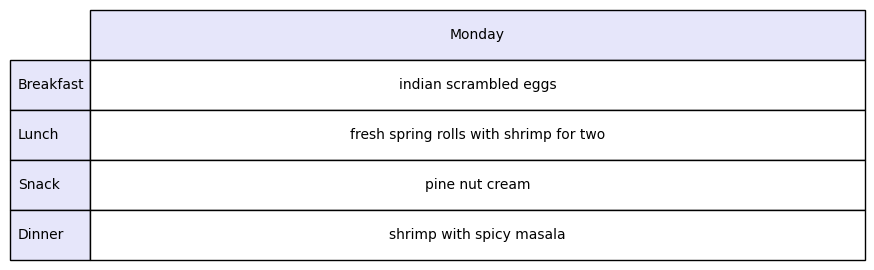

This is the modified meal plan for Monday


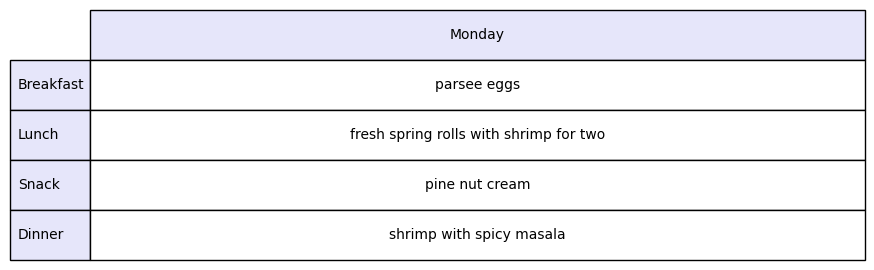

In [16]:
pd.set_option('display.max_rows', None)
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print("Hey user "+str(user)+ ", Let's create a weekly meal plan together: \n")
full_plan=np.empty((4,7), dtype=object)

for i,day in enumerate(days_of_the_week):
    fail_filt_input = ''
    
    arr_day = np.empty((4,1), dtype=object)
    print("This is our recommended meal plan for "+day)
    print(f"This is the meal plan: Breakfast ({recipes_final_breakfast_filtered['name'].iloc[0]})")
    print(f"This is the meal plan: Lunch ({recipes_final_lunch_filtered['name'].iloc[0]})")
    print(f"This is the meal plan: Snack ({recipes_final_snack_filtered['name'].iloc[0]})")
    print(f"This is the meal plan: Dinner ({recipes_final_dinner_filtered['name'].iloc[0]})")

    arr_day[0]=recipes_final_breakfast_filtered['name'].iloc[0]
    arr_day[1]=recipes_final_lunch_filtered['name'].iloc[0]     
    arr_day[2]=recipes_final_snack_filtered['name'].iloc[0]
    arr_day[3]=recipes_final_dinner_filtered['name'].iloc[0]

    plt.rcParams["figure.figsize"] =[5, 1]
    fig, axs = plt.subplots(1, 1)
    rows = ("Breakfast","Lunch","Snack","Dinner")
    columns=day
    axs.axis('tight')
    axs.axis('off')

    the_table = axs.table(cellText=arr_day,
                          cellLoc="center", 
                          colLabels=[day.strip() for day1 in day],
                          rowLabels=rows, 
                          loc='center',
                          colColours=np.full(len(columns), 'lavender'),
                          rowColours=np.full(len(rows), 'lavender'))
    
    the_table.scale(2,3)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10) 
    plt.show()
    
    if i + 1 < len(days_of_the_week):
        user_option = input(f"{day.upper()} || Breakfast: {arr_day[0]} Lunch: {arr_day[1]} Snack: {arr_day[2]} Dinner: {arr_day[3]} || Select one: (a,b,c) : A. Proceed to the next day ({days_of_the_week[i+1].upper()})  B. Change the Menu  C. More Info").lower()
    else:
        user_option = input(f"{day.upper()} || Breakfast: {arr_day[0]} Lunch: {arr_day[1]} Snack: {arr_day[2]} Dinner: {arr_day[3]} || Select one: (a,b,c) : A. This is our last day, end the recommendation  B. Change the Menu  C. More Info").lower()
    
    # Option C: More Info
    if(user_option=='c'):
        while(user_option =='c'):
            meal_sel_info=input(f"{day.upper()} || More Info selected ||Select which meal (a,b,c,d) ? : A. Breakfast {arr_day[0]} B. Lunch {arr_day[1]} C. Snack {arr_day[2]}  D. Dinner {arr_day[3]}").lower()
            if(meal_sel_info=="a"):
                display_recipe(recipes_final_breakfast_filtered, i)
            if(meal_sel_info=="b"):
                display_recipe(recipes_final_lunch_filtered, i)
            if(meal_sel_info=="c"):
                display_recipe(recipes_final_snack_filtered, i)
            if(meal_sel_info=="d"):
                display_recipe(recipes_final_dinner_filtered, i)
                
            next_option=input(f"{day.upper()} || After displaying the information, what do you want to do next (a,b,c) : \n A. Proceed to the next day ({days_of_the_week[i+1].upper()})  \n B. Change the Menu \n C. More Info \n").lower()
            if(next_option=='a'):
                user_option='a'
            elif(next_option=='b'):
                user_option='b'

    # Option A: Proceed to the next day (if users have gone through exclusion or withdrawal, check the flags and updating the remaining rows in dataframe, omittitng the first instance of the recipe too)
    if(user_option=='a'):
        #flag dynamic
        if flag_dynamic_br == True:
            for index, row in recipes_final_breakfast_filtered.iterrows():
                recipes_final_breakfast_filtered.loc[index, 'rating'] += (or_rat_br.loc[index, 'rating']-recipes_final_breakfast_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu == True:
            for index, row in recipes_final_lunch_filtered.iterrows():
                recipes_final_lunch_filtered.loc[index, 'rating'] += (or_rat_lu.loc[index, 'rating']-recipes_final_lunch_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn == True:
            for index, row in recipes_final_snack_filtered.iterrows():
                recipes_final_snack_filtered.loc[index, 'rating'] += (or_rat_sn.loc[index, 'rating']-recipes_final_snack_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di == True:
            for index, row in recipes_final_dinner_filtered.iterrows():
                recipes_final_dinner_filtered.loc[index, 'rating'] += (or_rat_di.loc[index, 'rating']-recipes_final_dinner_filtered.loc[index, 'rating'])/(7-i+1)        
        #flag dynamic filtered
        if flag_dynamic_br_filt == True:
            for index, row in recipes_final_breakfast_filtered.iterrows():
                recipes_final_breakfast_filtered.loc[index, 'rating'] -= (or_rat_br.loc[index, 'rating']-recipes_final_breakfast_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu_filt == True:
            for index, row in recipes_final_lunch_filtered.iterrows():
                recipes_final_lunch_filtered.loc[index, 'rating'] -= (or_rat_lu.loc[index, 'rating']-recipes_final_lunch_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn_filt == True:
            for index, row in recipes_final_snack_filtered.iterrows():
                recipes_final_snack_filtered.loc[index, 'rating'] -= (or_rat_sn.loc[index, 'rating']-recipes_final_snack_filtered.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di_filt ==True:
            for index, row in recipes_final_dinner_filtered.iterrows():
                recipes_final_dinner_filtered.loc[index, 'rating'] -= (or_rat_di.loc[index, 'rating']-recipes_final_dinner_filtered.loc[index, 'rating'])/(7-i+1)  

        recipes_final_breakfast_filtered=recipes_final_breakfast_filtered.iloc[1:]
        recipes_final_lunch_filtered=recipes_final_lunch_filtered.iloc[1:]
        recipes_final_snack_filtered=recipes_final_snack_filtered.iloc[1:]
        recipes_final_dinner_filtered=recipes_final_dinner_filtered.iloc[1:]
        
        full_plan[:,i]=arr_day[:,0]
    

    ######Option B: CHANGE THE MENU PLEASE #################
    elif(user_option == 'b'):
        exit_b = ''
        while exit_b != 'a':
            meal_sel=input(f"CHANGING MENU FOR {day.upper()}: Which meal? : A. BREAKFAST {arr_day[0]} B. LUNCH {arr_day[1]} C. SNACK {arr_day[2]} D. DINNER {arr_day[3]}").lower()
            meal_exclude = None

            if meal_sel == "a":
                meal_exclude = input(f"CHANGING BREAKFAST: what do you want to do with this recipe? ({arr_day[0]}) (a,b): \n A. WITHDRAWAL (recommend again in the future) \n B. EXCLUSION (leave out from future recommendations) \n").lower()
            elif meal_sel == "b":
                meal_exclude = input(f"CHANGING LUNCH: what do you want to do with this recipe? ({arr_day[1]}) (a,b): \n A. WITHDRAWAL (recommend again in the future) \n B. EXCLUSION (leave out from future recommendations) \n").lower()
            elif meal_sel == "c":
                meal_exclude = input(f"CHANGING SNACK: what do you want to do with this recipe? ({arr_day[2]}) (a,b): \n A. WITHDRAWAL (recommend again in the future) \n B. EXCLUSION (leave out from future recommendations) \n").lower()
            elif meal_sel == "d":
                meal_exclude = input(f"CHANGING DINNER: what do you want to do with this recipe? ({arr_day[3]}) (a,b): \n A. WITHDRAWAL (recommend again in the future) \n B. EXCLUSION (leave out from future recommendations) \n").lower()
                
            ### A)) WITHDRAWAL
            if (meal_exclude == "a"):
                j = i
                if(meal_sel == "a"):
                    recipes_final_breakfast_filtered, withdrawal_breakfast, flag_dynamic_br, count_with_br = meal_withdrawals(recipes_final_breakfast_filtered, withdrawal_breakfast, Mean, user, flag_dynamic_br, count_with_br)
                    arr_day[0] = recipes_final_breakfast_filtered['name'].iloc[0]
                if(meal_sel == "b"):
                    recipes_final_lunch_filtered, withdrawal_lunch, flag_dynamic_lu, count_with_lu = meal_withdrawals(recipes_final_lunch_filtered, withdrawal_lunch, Mean, user, flag_dynamic_lu, count_with_lu)
                    arr_day[1] = recipes_final_lunch_filtered['name'].iloc[0]   
                if(meal_sel == "c"):
                    recipes_final_snack_filtered, withdrawal_snack, flag_dynamic_sn, count_with_sn = meal_withdrawals(recipes_final_snack_filtered, withdrawal_snack, Mean, user, flag_dynamic_sn, count_with_sn)
                    arr_day[2] = recipes_final_snack_filtered['name'].iloc[0]     
                if(meal_sel == "d"):
                    recipes_final_dinner_filtered, withdrawal_dinner, flag_dynamic_di, count_with_di = meal_withdrawals(recipes_final_dinner_filtered, withdrawal_dinner, Mean, user, flag_dynamic_di, count_with_di)
                    arr_day[3] = recipes_final_dinner_filtered['name'].iloc[0]

            ### B)) EXCLUSION
            elif (meal_exclude == "b"):
                j = i
                if meal_sel == "a":
                    recipes_final_breakfast_filtered, excluded_breakfast, flag_dynamic_br, count_excl_br = meal_exclusions(recipes_final_breakfast_filtered, excluded_breakfast, Mean, user, flag_dynamic_br, count_excl_br)
                    arr_day[0] = recipes_final_breakfast_filtered['name'].iloc[0]
                if(meal_sel == "b"):
                    recipes_final_lunch_filtered, excluded_lunch, flag_dynamic_lu, count_excl_lu = meal_exclusions(recipes_final_lunch_filtered, excluded_lunch, Mean, user, flag_dynamic_lu, count_excl_lu)
                    arr_day[1] = recipes_final_lunch_filtered['name'].iloc[0]               
                if(meal_sel == "c"):
                    recipes_final_snack_filtered, excluded_snack, flag_dynamic_sn, count_excl_sn = meal_exclusions(recipes_final_snack_filtered, excluded_snack, Mean, user, flag_dynamic_sn, count_excl_sn)
                    arr_day[2] = recipes_final_snack_filtered['name'].iloc[0]           
                if(meal_sel == "d"):
                    recipes_final_dinner_filtered, excluded_dinner, flag_dynamic_di, count_excl_di = meal_exclusions(recipes_final_dinner_filtered, excluded_dinner, Mean, user, flag_dynamic_di, count_excl_di)
                    arr_day[3] = recipes_final_dinner_filtered['name'].iloc[0]

            ### C)) FILTERING
            if (meal_exclude == "b"):
                if meal_sel == "a":
                    user_option_filt = input(f"EXCLUSION performed for BREAKFAST, this is your new recipe {arr_day[0]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[0] = recipes_final_breakfast_filtered['name'].iloc[0]
                elif meal_sel == "b":
                    user_option_filt = input(f"EXCLUSION performed for LUNCH, this is your new recipe {arr_day[1]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[1] = recipes_final_lunch_filtered['name'].iloc[0]
                elif meal_sel == "c":
                    user_option_filt = input(f"EXCLUSION performed for SNACK, this is your new recipe {arr_day[2]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[2] = recipes_final_snack_filtered['name'].iloc[0]
                elif meal_sel == "d":
                    user_option_filt = input(f"EXCLUSION performed for DINNER, this is your new recipe {arr_day[3]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[3] = recipes_final_dinner_filtered['name'].iloc[0]
            elif (meal_exclude=="a"):
                if meal_sel == "a":
                    user_option_filt = input(f"WITHDRAWAL performed for BREAKFAST, this is your new recipe {arr_day[0]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[0] = recipes_final_breakfast_filtered['name'].iloc[0]
                elif meal_sel == "b":
                    user_option_filt = input(f"WITHDRAWAL performed for LUNCH, this is your new recipe {arr_day[1]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[1] = recipes_final_lunch_filtered['name'].iloc[0]
                elif meal_sel == "c":
                    user_option_filt = input(f"WITHDRAWAL performed for SNACK, this is your new recipe {arr_day[2]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[2] = recipes_final_snack_filtered['name'].iloc[0]
                elif meal_sel == "d":
                    user_option_filt = input(f"WITHDRAWAL performed for DINNER, this is your new recipe {arr_day[3]}, now do you want to apply further FILTERING? (a,b) : \n A. YES B. NO \n").lower()
                    arr_day[3] = recipes_final_dinner_filtered['name'].iloc[0]

            meal_filt = user_option_filt                 
            # while fail_filt_input != 'b' and fail_filt_input != 'c' and fail_filt_input != "end" :
            while fail_filt_input != 'b' and fail_filt_input != "end" :
                if (meal_filt=="a"):
                    if(meal_sel== "a"):
                        option=input(f"There are three FILTERING criteria for {days_of_the_week[i].upper()} BREAKFAST, select one(A,B,C): A. Keyword B. Nutrition C. Both  ").upper()
                        breakfast_filter_recipe = ""
                        recipes_final_breakfast_filtered, flag_dynamic_br_filt, fail_filt_input, breakfast_filter_recipe = filter_recipes(recipes_final_breakfast_filtered, Mean, user, i, flag_dynamic_br_filt, fail_filt_input, option, breakfast_filter_recipe)
                        arr_day[0] = breakfast_filter_recipe
                        if breakfast_filter_recipe == None:
                            fail_filt_input = input("Sorry no matching recipes for the applied filtering criteria. Select the next option (A,B): \n A. New filter please \n B. I don't want to do another filtering\n ")

                    if(meal_sel=="b"):
                        option=input(f"There are three FILTERING criteria for {days_of_the_week[i].upper()} LUNCH, select one(A,B,C): A. Keyword B. Nutrition C. Both  ").upper()
                        if(keyw_flag == False and nutr_flag == False):
                            arr_day[1] = filter_recipes(recipes_final_lunch_filtered, Mean, user, i, flag_dynamic_lu_filt, fail_filt_input, option)
                        else:
                            fail_filt_input = input("Sorry no matching recipes for the applied filtering criteria. Select the next option (A,B): \n A. New filter please \n B. I don't want to do another filtering\n ")
                    if(meal_sel=="c"):
                        option=input(f"There are three FILTERING criteria for {days_of_the_week[i].upper()} SNACK, select one(A,B,C): A. Keyword B. Nutrition C. Both  ").upper()
                        if(keyw_flag == False and nutr_flag == False):
                            arr_day[2] = filter_recipes(recipes_final_snack_filtered, Mean, user, i, flag_dynamic_sn_filt, fail_filt_input, option)
                        else:
                            fail_filt_input = input("Sorry no matching recipes for the applied filtering criteria. Select the next option (A,B): \n A. New filter please \n B. I don't want to do another filtering\n ")

                    if(meal_sel=="d"):
                        option=input(f"There are three FILTERING criteria for {days_of_the_week[i].upper()} DINNER, select one(A,B,C): A. Keyword B. Nutrition C. Both  ").upper()
                        if(keyw_flag == False and nutr_flag == False):
                            arr_day[3] = filter_recipes(recipes_final_dinner_filtered, Mean, user, i, flag_dynamic_di_filt, fail_filt_input, option)
                        else:
                            fail_filt_input = input("Sorry no matching recipes for the applied filtering criteria. Select the next option (A,B): \n A. New filter please \n B. I don't want to do another filtering\n ")
                            
                if meal_filt=="b" or fail_filt_input=='b' :
                    j=i
                    fail_filt_input = "end"
                    if(meal_sel=="a"):
                        arr_day[0]=recipes_final_breakfast_filtered['name'].iloc[0]
                    if(meal_sel=="b"):
                        arr_day[1]=recipes_final_lunch_filtered['name'].iloc[0]   
                    if(meal_sel=="c"):                
                        arr_day[2]=recipes_final_snack_filtered['name'].iloc[0]
                    if(meal_sel=="d"):
                        arr_day[3]=recipes_final_dinner_filtered['name'].iloc[0]

            #Display modified meal plan
            print("This is the modified meal plan for "+day)            
            plt.rcParams["figure.figsize"] =[5, 1]
            fig, axs = plt.subplots(1, 1)
            rows = ("Breakfast","Lunch","Snack","Dinner")
            axs.axis('tight')
            axs.axis('off')
            the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
            the_table.scale(2,3)
            the_table.auto_set_font_size(False)
            the_table.set_fontsize(10) 
            plt.show()
            
            exit_b=input(f"Are you satisfied with this {days_of_the_week[i].upper()}'s menu: BREAKFAST: {arr_day[0]}, LUNCH: {arr_day[1]}, SNACK: {arr_day[2]}, DINNER: {arr_day[3]} |||| \n A. Proceed to next day {days_of_the_week[i+1].upper()} \n B. Make another change \n")
            
            if(exit_b=="a"):
                if flag_dynamic_br == True:
                    for index, row in recipes_final_breakfast_filtered.iterrows():
                        recipes_final_breakfast_filtered.loc[index, 'rating'] += (or_rat_br.loc[index, 'rating'] - recipes_final_breakfast_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu == True:
                    for index, row in recipes_final_lunch_filtered.iterrows():
                        recipes_final_lunch_filtered.loc[index, 'rating'] += (or_rat_lu.loc[index, 'rating'] - recipes_final_lunch_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn == True:
                    for index, row in recipes_final_snack_filtered.iterrows():
                        recipes_final_snack_filtered.loc[index, 'rating'] += (or_rat_sn.loc[index, 'rating'] - recipes_final_snack_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di == True:
                    for index, row in recipes_final_dinner_filtered.iterrows():
                        recipes_final_dinner_filtered.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner_filtered.loc[index, 'rating'])/(7-i+1)               
                
                if flag_dynamic_br_filt == True:
                    for index, row in recipes_final_breakfast_filtered.iterrows():
                        recipes_final_breakfast_filtered.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu_filt == True:
                    for index, row in recipes_final_lunch_filtered.iterrows():
                        recipes_final_lunch_filtered.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn_filt == True:
                    for index, row in recipes_final_snack_filtered.iterrows():
                        recipes_final_snack_filtered.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack_filtered.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di_filt == True:
                    for index, row in recipes_final_dinner_filtered.iterrows():
                        recipes_final_dinner_filtered.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner_filtered.loc[index, 'rating'])/(7-i+1)  
                
                
                
                full_plan[:,i]=arr_day[:,0]
                recipes_final_breakfast_filtered=recipes_final_breakfast_filtered.iloc[1:]
                recipes_final_lunch_filtered=recipes_final_lunch_filtered.iloc[1:]
                recipes_final_snack_filtered=recipes_final_snack_filtered.iloc[1:]
                recipes_final_dinner_filtered=recipes_final_dinner_filtered.iloc[1:]


plt.rcParams["figure.figsize"] =[20, 1]
fig, axs = plt.subplots(1, 1)
columns = ("Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
rows = ("Breakfast","Lunch","Snack","Dinner")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=full_plan,cellLoc="center", colLabels=columns,rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
the_table.scale(2,6)

the_table.auto_set_font_size(False)
the_table.set_fontsize(14) 
plt.title("Meal/Day of the week",y=4,fontsize=20) 
plt.show()

In [ ]:
#create dataframes for each chronic disease that include the tags we are about to use to recommend recipes  
cancer = pd.DataFrame({'high-protein', 'high-fiber', 'low-saturated-fat', 'low-sodium'})
obesity = pd.DataFrame({'high-protein', 'low-fat', 'low-saturated-fat', 'low-calorie','high-calcium','low-carb'})
diabetes = pd.DataFrame({'diabetic'})
heart = pd.DataFrame({'high-protein', 'high-fiber', 'low-saturated-fat', 'low-sodium','low-cholesterol','low-carb'})
dental = pd.DataFrame({'high-protein', 'high-fiber','low-sodium','low-carb','high-calcium'})
osteoporosis = pd.DataFrame({'high-protein', 'high-calcium', 'low-saturated-fat', 'low-sodium'})
diab=False

In [ ]:
#count how many diseases the user has
count_diseases=users_health.loc[user].value_counts().get(True, 0)
if users_health.loc[user].value_counts('Diabetes').get(True, 0)==1:
    diab=True
    count_diseases=count_diseases-1

In [ ]:
#create the user health profile 
health_history_df=pd.DataFrame({})
for_explanation_print_diseases=''
if users_health.loc[user,'Cancer']:
    health_history_df=pd.concat([health_history_df, cancer], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Cancer patient,'
    
if users_health.loc[user,'Obesity']:
    health_history_df=pd.concat([health_history_df, obesity], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Obese,'
    
if users_health.loc[user,'Diabetes']:
    health_history_df=pd.concat([health_history_df, diabetes], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Diabetic,'

if users_health.loc[user,'Cardiovascular']:
    health_history_df=pd.concat([health_history_df, heart], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Ηeart patient,'

if users_health.loc[user,'Dental']:
    health_history_df=pd.concat([health_history_df, dental], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Dental patient,'

if users_health.loc[user,'Osteoporosis']:
    health_history_df=pd.concat([health_history_df, osteoporosis], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Osteoporosis patient,'

if count_diseases==0:
    for_explanation_print_diseases='Healthy user'

In [ ]:
#users_health.loc[user]

In [ ]:
#health_history_df

In [ ]:
#when the user has chronic disease
if not health_history_df.empty:
    health_history_df = health_history_df.rename(columns={0: 'tag'})
    health_history_df['occurrences'] = health_history_df.groupby('tag')['tag'].transform('count')
    health_history_df=health_history_df.drop_duplicates().sort_values(by='occurrences', ascending=False)
    #edw einai se sxolio giati se kapoies periptwseis den ypirxan alla fagita opote ekana pio elastiko to periorismo twn tags
    
    while(health_history_df[health_history_df['occurrences'] == count_diseases].empty):
        count_diseases=count_diseases-1
    health_history_df=health_history_df[health_history_df['occurrences'] == count_diseases]
    
    if diab==True:
        health_history_df=health_history_df.append({'tag':'diabetic'}, ignore_index = True)

    for x in health_history_df['tag'].astype(str).tolist():
        health_recipes_final_filtering_final=recipes_final[recipes_final[x]==True]

    if diab==True:
        health_recipes_final_filtering_final=recipes_final[recipes_final['diabetic']==True]


In [ ]:
#health_history_df

In [ ]:
recipes_final_breakfast = health_recipes_final_filtering_final[health_recipes_final_filtering_final['breakfast'] == True]
recipes_final_lunch = health_recipes_final_filtering_final[health_recipes_final_filtering_final['lunch'] == True]
recipes_final_snack = health_recipes_final_filtering_final[health_recipes_final_filtering_final['snacks'] == True]
recipes_final_dinner = health_recipes_final_filtering_final[health_recipes_final_filtering_final['dinner'] == True]

In [ ]:
flag_br=False
flag_lu=False
flag_sn=False
flag_di=False

if(len(recipes_final_breakfast)<10):
    flag_br=True
    br_len=len(recipes_final_breakfast)
    recipes_final_breakfast=pd.concat([recipes_final_breakfast] * 10, ignore_index=True)
if(len(recipes_final_lunch)<10):
    lu_len=len(recipes_final_lunch)
    flag_lu=True
    recipes_final_lunch=pd.concat([recipes_final_lunch] * 10, ignore_index=True)
if(len(recipes_final_snack)<10):
    sn_len=len(recipes_final_snack)
    flag_sn=True
    recipes_final_snack=pd.concat([recipes_final_snack] * 10, ignore_index=True)
if(len(recipes_final_dinner)<10):
    di_len=len(recipes_final_dinner)
    flag_di=True
    recipes_final_dinner=pd.concat([recipes_final_dinner] * 10, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

print("Hey user "+str(user)+ ", together we will create a weekly meal plan suitable for your health condition(s) and adjusted to your personal preferences \n")

full_plan=np.empty((4,7), dtype=object)

excluded_breakfast=pd.DataFrame(columns=recipes_final.columns)
excluded_lunch=pd.DataFrame(columns=recipes_final.columns)
excluded_snack=pd.DataFrame(columns=recipes_final.columns)
excluded_dinner=pd.DataFrame(columns=recipes_final.columns)

withdrawal_breakfast=pd.DataFrame(columns=recipes_final.columns)
withdrawal_lunch=pd.DataFrame(columns=recipes_final.columns)
withdrawal_snack=pd.DataFrame(columns=recipes_final.columns)
withdrawal_dinner=pd.DataFrame(columns=recipes_final.columns)

excluded_breakfast=[]
excluded_lunch=[]
excluded_snack=[]
excluded_dinner=[]

withdrawal_breakfast=[]
withdrawal_lunch=[]
withdrawal_snack=[]
withdrawal_dinner=[]

count_excl_br=0
count_excl_lu=0
count_excl_sn=0
count_excl_di=0

count_with_br=0
count_with_lu=0
count_with_sn=0
count_with_di=0

or_rat_br=recipes_final_breakfast.copy()
or_rat_lu=recipes_final_lunch.copy()
or_rat_di=recipes_final_dinner.copy()
or_rat_sn=recipes_final_snack.copy()
weight=0
flag_dynamic_br=False
flag_dynamic_lu=False
flag_dynamic_sn=False
flag_dynamic_di=False

flag_dynamic_br_filt=False
flag_dynamic_lu_filt=False
flag_dynamic_sn_filt=False
flag_dynamic_di_filt=False


for i,day in enumerate(days_of_the_week):
    count_changes_breakfast=0
    count_changes_lunch=0
    count_changes_snack=0
    count_changes_dinner=0
    
    arr_day = np.empty((4,1), dtype=object)
    print("This is our recommended meal plan for "+day)
    arr_day[0]=recipes_final_breakfast['name'].iloc[i]
    arr_day[1]=recipes_final_lunch['name'].iloc[i]     
    arr_day[2]=recipes_final_snack['name'].iloc[i]
    arr_day[3]=recipes_final_dinner['name'].iloc[i]

    plt.rcParams["figure.figsize"] =[5, 1]
    fig, axs = plt.subplots(1, 1)
    rows = ("Breakfast","Lunch","Snack","Dinner")
    columns=day
    axs.axis('tight')
    axs.axis('off')
    the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
    the_table.scale(2,3)

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10) 
    #plt.title("Meal/Day of the week",y=4,fontsize=20) 
    plt.show()
    
    user_option = input("What do you want to do next (a,b,c) : \n a)It's ok for me,proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n") 
    
    if(user_option=='c'):
        while(user_option=='c'):
            
            meal_sel_info=input("About which meal do you want us to provide you with informations(a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            if(meal_sel_info=="a"):
                print("The recommended recipe for breakfast, names \""+ recipes_final_breakfast['name'].iloc[i]+"\", needs "+str(recipes_final_breakfast['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_breakfast['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_breakfast['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_breakfast['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_breakfast['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_breakfast['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_breakfast['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_breakfast['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_breakfast['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")       
            if(meal_sel_info=="b"):
                print("The recommended recipe for lunch, names \""+ recipes_final_lunch['name'].iloc[i]+"\", needs "+str(recipes_final_lunch['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_lunch['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_lunch['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_lunch['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_lunch['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_lunch['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_lunch['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_lunch['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_lunch['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="c"):
                print("The recommended recipe for snack, names \""+ recipes_final_snack['name'].iloc[i]+"\", needs "+str(recipes_final_snack['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_snack['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_snack['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_snack['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_snack['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_snack['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_snack['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_snack['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_snack['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="d"):
                print("The recommended recipe for dinner, names \""+ recipes_final_dinner['name'].iloc[i]+"\", needs "+str(recipes_final_dinner['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_dinner['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_dinner['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_dinner['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_dinner['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_dinner['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_dinner['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_dinner['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_dinner['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")


            next_option=input("Now after the informations about the recipe you saw,what do you want to do next (a,b,c) : \n a)Proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n")
            if(next_option=='a'):
                user_option='a'
            elif(next_option=='b'):
                user_option='b'
    
    if(user_option=='a'):
        if flag_dynamic_br ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)
                
        if flag_dynamic_br_filt ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu_filt ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn_filt ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di_filt ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  

        full_plan[:,i]=arr_day[:,0]
        recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
        recipes_final_lunch=recipes_final_lunch.iloc[1:]
        recipes_final_snack=recipes_final_snack.iloc[1:]
        recipes_final_dinner=recipes_final_dinner.iloc[1:]
    
    elif(user_option=='b'):      
        exit_b = ''
        # this will loop until response is not "exit"
        while exit_b != 'b':
            meal_sel=input("In which meal do you want us to make the change at (a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            
            meal_exclude=input("Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : \n a)Yes,recommend this recipe again in the future \n b)No,exclude it from future recommendations \n")
            
            meal_filt=input("Do you want to apply any filtering before the new recommendation (a,b) : \n a)Yes,show me how \n b)No \n")
            
            
            if (meal_exclude=="b"):
                j=i #check here if there is a problem
                if(meal_sel=="a"):
                    if(flag_br==True):
                        if(br_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(br_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible breakfast recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_breakfast=recipes_final_breakfast[~((recipes_final_breakfast['name'] == recipes_final_breakfast.iloc[0]['name']) & (recipes_final_breakfast.duplicated(subset='name', keep=False)))]
                                recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                                br_len=br_len-1
                    else:
                        count_excl_br=count_excl_br+1
                        if(count_excl_br==1):
                            excluded_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                            recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                        else:
                            set1 = set(excluded_breakfast)
                            ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_breakfast_ingredients = set1.intersection(set2)
                            recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                            for index, row in recipes_final_breakfast.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                                if common_ingredients:
                                    flag_dynamic_br=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_breakfast.loc[index, 'rating'] -= weight
                                    recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    if(flag_lu==True):
                        if(lu_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(lu_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible lunch recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_lunch=recipes_final_lunch[~((recipes_final_lunch['name'] == recipes_final_lunch.iloc[0]['name']) & (recipes_final_lunch.duplicated(subset='name', keep=False)))]
                                recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                                lu_len=lu_len-1
                    else:
                        count_excl_lu=count_excl_lu+1
                        if(count_excl_lu==1):
                            excluded_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                            recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                        else:
                            set1 = set(excluded_lunch)
                            ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_lunch_ingredients = set1.intersection(set2)
                            recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                            for index, row in recipes_final_lunch.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                                if common_ingredients:
                                    flag_dynamic_lu=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_lunch.loc[index, 'rating'] -= weight
                                    recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                if(meal_sel=="c"):
                    if(flag_sn==True):
                        if(sn_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(sn_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible snack recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_snack=recipes_final_snack[~((recipes_final_snack['name'] == recipes_final_snack.iloc[0]['name']) & (recipes_final_snack.duplicated(subset='name', keep=False)))]
                                recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                                sn_len=sn_len-1
                    else:
                        count_excl_sn=count_excl_sn+1
                        if(count_excl_sn==1):
                            excluded_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                            recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                        else:
                            set1 = set(excluded_snack)
                            ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_snack_ingredients = set1.intersection(set2)
                            recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                            for index, row in recipes_final_snack.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                                if common_ingredients:
                                    flag_dynamic_sn=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_snack.loc[index, 'rating'] -= weight
                                    recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    if(flag_di==True):
                        if(di_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(di_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible dinner recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):    
                                recipes_final_dinner=recipes_final_dinner[~((recipes_final_dinner['name'] == recipes_final_dinner.iloc[0]['name']) & (recipes_final_dinner.duplicated(subset='name', keep=False)))]
                                recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                                di_len=di_len-1
                    else:
                        count_excl_di=count_excl_di+1
                        if(count_excl_di==1):
                            excluded_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                            recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                        else:
                            set1 = set(excluded_dinner)
                            ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_dinner_ingredients = set1.intersection(set2)
                            recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                            for index, row in recipes_final_dinner.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                                if common_ingredients:
                                    flag_dynamic_di=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_dinner.loc[index, 'rating'] -= weight
                                    recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
            elif (meal_exclude=="a"):
                j=i #check here if there is a problem
                if(meal_sel=="a"):
                    if(flag_br==True):
                        if(br_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_breakfast = recipes_final_breakfast.shift(-1)
                            recipes_final_breakfast.iloc[-1] = recipes_final_breakfast.iloc[0] 
                    else:
                        count_with_br=count_with_br+1
                        if(count_with_br==1):
                            withdrawal_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_breakfast)
                            ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_breakfast_ingredients = set1.intersection(set2)
                            #recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                            for index, row in recipes_final_breakfast.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                                if common_ingredients:
                                    flag_dynamic_br=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_breakfast.loc[index, 'rating'] -= weight
                        recipes_final_breakfast.iloc[0, recipes_final_breakfast.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    if(flag_lu==True):
                        if(lu_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_lunch = recipes_final_lunch.shift(-1)
                            recipes_final_lunch.iloc[-1] = recipes_final_lunch.iloc[0] 
                    else:
                        count_with_lu=count_with_lu+1
                        if(count_with_lu==1):
                            withdrawal_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_lunch)
                            ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_lunch_ingredients = set1.intersection(set2)
                            #recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                            for index, row in recipes_final_lunch.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                                if common_ingredients:
                                    flag_dynamic_lu=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_lunch.loc[index, 'rating'] -= weight
                        recipes_final_lunch.iloc[0, recipes_final_lunch.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                if(meal_sel=="c"):
                    if(flag_sn==True):
                        if(sn_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_snack = recipes_final_snack.shift(-1)
                            recipes_final_snack.iloc[-1] = recipes_final_snack.iloc[0] 
                    else:
                        count_with_sn=count_with_sn+1
                        if(count_with_sn==1):
                            withdrawal_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_snack)
                            ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_snack_ingredients = set1.intersection(set2)
                            #recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                            for index, row in recipes_final_snack.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                                if common_ingredients:
                                    flag_dynamic_sn=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_snack.loc[index, 'rating'] -= weight
                        recipes_final_snack.iloc[0, recipes_final_snack.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)                    
                        recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    if(flag_di==True):
                        if(di_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_dinner = recipes_final_dinner.shift(-1)
                            recipes_final_dinner.iloc[-1] = recipes_final_dinner.iloc[0] 
                    else:
                        count_with_di=count_with_di+1
                        if(count_with_di==1):
                            withdrawal_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_dinner)
                            ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_dinner_ingredients = set1.intersection(set2)
                            #recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                            for index, row in recipes_final_dinner.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                                if common_ingredients:
                                    flag_dynamic_di=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_dinner.loc[index, 'rating'] -= weight                        
                        recipes_final_dinner.iloc[0, recipes_final_dinner.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
                
                
            fail_filt_input=''
            while fail_filt_input != 'b' and fail_filt_input != 'c' and fail_filt_input != "end" :
                #print("iiiii")
                if (meal_filt=="a"):
                    option=input("There are three filtering options to choose from, choose the one you want(a,b,c): \n a)Keyword \n b)Nutrition \n c)Both \n  ")
                    if(meal_sel=="a"):
                            recipes_breakfast_filtering=recipes_final_breakfast
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_br_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_breakfast.loc[recipes_final_breakfast['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                    
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[0]=recipes_breakfast_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="b"):
                            recipes_lunch_filtering=recipes_final_lunch
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)]

                                    flag_dynamic_lu_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_lunch.loc[recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)                                        
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[1]=recipes_lunch_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="c"):
                            recipes_snack_filtering=recipes_final_snack
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_sn_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_snack.loc[recipes_final_snack['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[2]=recipes_snack_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="d"):    
                            recipes_dinner_filtering=recipes_final_dinner
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_di_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_dinner.loc[recipes_final_dinner['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[3]=recipes_dinner_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")
                if meal_filt=="b"or fail_filt_input=='b' :
                    j=i #check here if there is a problem
                    fail_filt_input = "end"
                    if(meal_sel=="a"):
                        arr_day[0]=recipes_final_breakfast['name'].iloc[i]
                    if(meal_sel=="b"):
                        arr_day[1]=recipes_final_lunch['name'].iloc[i]   
                    if(meal_sel=="c"):                
                        arr_day[2]=recipes_final_snack['name'].iloc[i]
                    if(meal_sel=="d"):
                        arr_day[3]=recipes_final_dinner['name'].iloc[i]
            print("This is the modified meal plan for "+day)            
            
            plt.rcParams["figure.figsize"] =[5, 1]
            fig, axs = plt.subplots(1, 1)
            rows = ("Breakfast","Lunch","Snack","Dinner")
            axs.axis('tight')
            axs.axis('off')
            the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
            the_table.scale(2,3)

            the_table.auto_set_font_size(False)
            the_table.set_fontsize(10) 
            #plt.title("Meal/Day of the week",y=4,fontsize=20) 
            plt.show()
            
            exit_b=input(f"Are you satisfied or do you want to make some other change?(a,b) Current meal plan  : \n A. Make another change \n B. Proceed to next day \n")
            
            if(exit_b=="b"):
                if flag_dynamic_br ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)               
                
                if flag_dynamic_br_filt ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu_filt ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn_filt ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di_filt ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  
                
                
                
                full_plan[:,i]=arr_day[:,0]
                recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
                recipes_final_lunch=recipes_final_lunch.iloc[1:]
                recipes_final_snack=recipes_final_snack.iloc[1:]
                recipes_final_dinner=recipes_final_dinner.iloc[1:]


plt.rcParams["figure.figsize"] =[20, 1]
fig, axs = plt.subplots(1, 1)
columns = ("Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
rows = ("Breakfast","Lunch","Snack","Dinner")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=full_plan,cellLoc="center", colLabels=columns,rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
the_table.scale(2,6)

the_table.auto_set_font_size(False)
the_table.set_fontsize(14) 
plt.title("Meal/Day of the week",y=4,fontsize=20) 
plt.show()

In [ ]:
'''
df = pd.read_csv("RAW_recipes.csv",encoding="Latin1")

tags_column = df['tags']

all_tags = []

for tags in tags_column:
    all_tags.extend(eval(tags))

tag_counts = pd.Series(all_tags).value_counts()

tag_counts_df = pd.DataFrame({'Tag': tag_counts.index, 'Count': tag_counts.values})

tag_counts_df.to_excel('tag_counts.xlsx', index=False)
'''

In [ ]:
'''

df = pd.read_csv("RAW_recipes.csv",encoding="Latin1")

ingredients_column = df['ingredients']

all_ingredients = []

for ingredients in ingredients_column:
    all_ingredients.extend(eval(ingredients))

ingredients_counts = pd.Series(all_ingredients).value_counts()

ingredients_counts_df = pd.DataFrame({'Ingredient': tag_counts.index, 'Count': tag_counts.values})

ingredients_counts_df.to_excel('ingredients_counts.xlsx', index=False)
'''